In [1]:
import pandas as pd
import numpy as np
import ast
import wfdb
from pytorch_forecasting.data import TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer

# Utility Functions

In [2]:

def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
        #print(data)
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

def aggregate_diagnostic(y_dic):
    #print(y_dic)
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            #print(key)
            tmp.append(agg_df.loc[key].diagnostic_class)
    #print(agg_df)
    #print(tmp)
    return list(set(tmp))

def process_patient_data(patient_id, age,sex,ecg_id, filename_lr, path):
    """
    Load ECG waveform data for a single patient and combine with their static information.

    Args:
        patient_id (int): The ID of the patient.
        age (int): The age of the patient.
        filename_lr (str): Path to the patient's waveform data file (low resolution).
        path (str): Base path to the waveform data files.

    Returns:
        pd.DataFrame: A DataFrame containing ECG waveform data and static info for the patient.
    """
    # Load the waveform data using wfdb
    signal, meta = wfdb.rdsamp( filename_lr)
    
    # Create a DataFrame for the time-series ECG data
    num_timesteps, num_leads = signal.shape
    time_idx = np.arange(num_timesteps)
    ecg_df = pd.DataFrame(signal, columns=[f"lead_{i}" for i in range(num_leads)])
    ecg_df["time_idx"] = time_idx
    
    # Add static patient information
    ecg_df["patient_id"] = patient_id
    ecg_df["age"] = age
    ecg_df["sex"] = sex
    ecg_df["ecg_id"] = ecg_id
    
    # Reorder columns for clarity
    columns = ["ecg_id","patient_id","time_idx", "age", "sex"] + [f"lead_{i}" for i in range(num_leads)]
    ecg_df = ecg_df[columns]
    
    return ecg_df


# Read Data 

In [3]:
path=''
df = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
#df=df[(df["patient_id"] == 381.0) & (df.index== 693)]
df = df[df['filename_lr'].str.contains(r'^records100/00000/')]
# Process all patients
all_patients = []

for _, row in df.iterrows():
    patient_data = process_patient_data(
        patient_id=row["patient_id"],
        ecg_id=row.name,
        age=row["age"],
        sex=row["sex"],
        filename_lr=row["filename_lr"],
        path=""
    )
    all_patients.append(patient_data)

# Combine all patients into a single DataFrame
final_df = pd.concat(all_patients, ignore_index=True)

#print(final_df.head())

In [4]:
final_df.head()

,ecg_id,patient_id,time_idx,age,sex,lead_0,lead_1,lead_2,lead_3,lead_4,lead_5,lead_6,lead_7,lead_8,lead_9,lead_10,lead_11
0,1,15709.0,0,56.0,1,-0.119,-0.055,0.064,0.086,-0.091,0.004,-0.069,-0.031,0.000,-0.026,-0.039,-0.079
1,1,15709.0,1,56.0,1,-0.116,-0.051,0.065,0.083,-0.090,0.006,-0.064,-0.036,-0.003,-0.031,-0.034,-0.074
2,1,15709.0,2,56.0,1,-0.120,-0.044,0.076,0.082,-0.098,0.016,-0.058,-0.034,-0.010,-0.028,-0.029,-0.069
3,1,15709.0,3,56.0,1,-0.117,-0.038,0.080,0.077,-0.098,0.021,-0.050,-0.030,-0.015,-0.023,-0.022,-0.064
4,1,15709.0,4,56.0,1,-0.103,-0.031,0.072,0.066,-0.087,0.021,-0.045,-0.027,-0.020,-0.019,-0.018,-0.058


# Transform Target Variable

In [5]:
df.scp_codes_converted = df.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]
agg_df=agg_df[["diagnostic_subclass","diagnostic_class"]]

# Aggregate diagnostic labels into binary classification
df['diagnostic_class'] = df.scp_codes_converted.apply(aggregate_diagnostic)
df['target'] = df.diagnostic_class.apply(lambda x: 1 if 'MI' in x else 0)  # Binary MI target

df_target=df[['patient_id','target','diagnostic_class']]

C:\Users\anike\AppData\Local\Temp\ipykernel_40060\2370189137.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.scp_codes_converted = df.scp_codes.apply(lambda x: ast.literal_eval(x))


In [6]:
df_target.head()

,patient_id,target,diagnostic_class
ecg_id,,,
1,15709.0,0,[NORM]
2,13243.0,0,[NORM]
3,20372.0,0,[NORM]
4,17014.0,0,[NORM]
5,17448.0,0,[NORM]


# Merge Target Variable

In [7]:
df_merged = final_df.merge(df_target, on=["patient_id","ecg_id"], how="left")

In [8]:
df_merged.head()

,ecg_id,patient_id,time_idx,age,sex,lead_0,lead_1,lead_2,lead_3,lead_4,lead_5,lead_6,lead_7,lead_8,lead_9,lead_10,lead_11,target,diagnostic_class
0,1,15709.0,0,56.0,1,-0.119,-0.055,0.064,0.086,-0.091,0.004,-0.069,-0.031,0.000,-0.026,-0.039,-0.079,0,[NORM]
1,1,15709.0,1,56.0,1,-0.116,-0.051,0.065,0.083,-0.090,0.006,-0.064,-0.036,-0.003,-0.031,-0.034,-0.074,0,[NORM]
2,1,15709.0,2,56.0,1,-0.120,-0.044,0.076,0.082,-0.098,0.016,-0.058,-0.034,-0.010,-0.028,-0.029,-0.069,0,[NORM]
3,1,15709.0,3,56.0,1,-0.117,-0.038,0.080,0.077,-0.098,0.021,-0.050,-0.030,-0.015,-0.023,-0.022,-0.064,0,[NORM]
4,1,15709.0,4,56.0,1,-0.103,-0.031,0.072,0.066,-0.087,0.021,-0.045,-0.027,-0.020,-0.019,-0.018,-0.058,0,[NORM]


In [9]:
grouped=df_merged[df_merged["patient_id"]==381.0].groupby(['ecg_id','patient_id','target']).size()
grouped.head()

ecg_id  patient_id  target
693     381.0       1         1000
761     381.0       1         1000
990     381.0       1         1000
997     381.0       1         1000
dtype: int64

In [10]:
type(grouped)

pandas.core.series.Series

# Visualize the Waveform data

In [11]:
import matplotlib.pyplot as plt

Select Patients with the Symptoms of MI

In [12]:
# Filter data for a specific patient (e.g., patient_id = 15709.0)
patient_data = df_merged[(df_merged["patient_id"] == 381.0) & (df_merged["ecg_id"] == 693)]

In [13]:
patient_data.head()

,ecg_id,patient_id,time_idx,age,sex,lead_0,lead_1,lead_2,lead_3,lead_4,lead_5,lead_6,lead_7,lead_8,lead_9,lead_10,lead_11,target,diagnostic_class
680000,693,381.0,0,85.0,1,0.094,0.035,-0.060,-0.064,0.077,-0.012,-0.060,-0.070,-0.060,-0.189,-0.384,-0.349,1,[MI]
680001,693,381.0,1,85.0,1,0.087,0.035,-0.052,-0.061,0.069,-0.008,-0.061,-0.071,-0.055,-0.191,-0.386,-0.351,1,[MI]
680002,693,381.0,2,85.0,1,0.076,0.035,-0.042,-0.055,0.058,-0.003,-0.057,-0.072,-0.054,-0.193,-0.388,-0.353,1,[MI]
680003,693,381.0,3,85.0,1,0.057,0.035,-0.022,-0.046,0.039,0.006,-0.068,-0.083,-0.081,-0.193,-0.393,-0.353,1,[MI]
680004,693,381.0,4,85.0,1,0.031,0.035,0.004,-0.033,0.013,0.019,-0.074,-0.093,-0.093,-0.205,-0.410,-0.364,1,[MI]


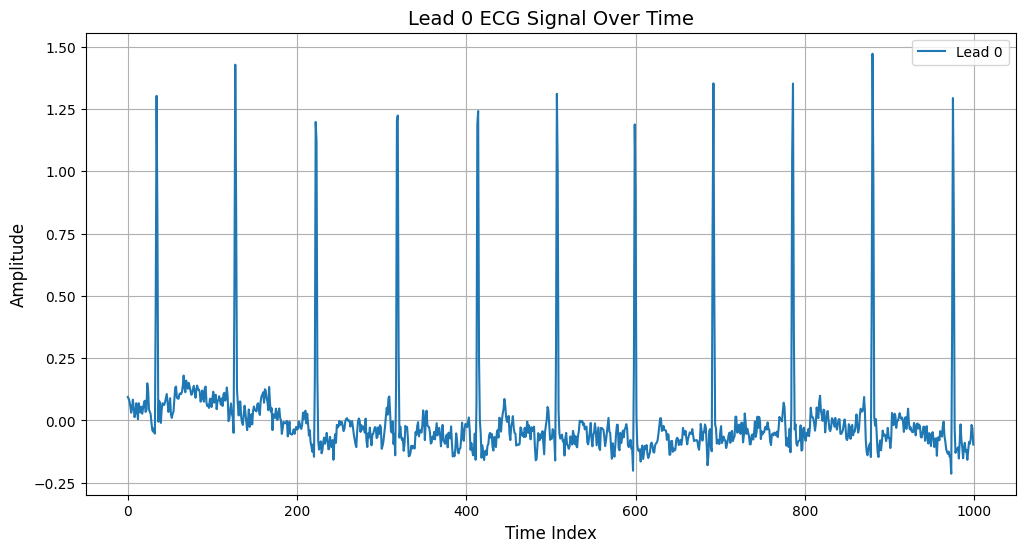

In [14]:
# Plot the lead_0 data over time for the patient
plt.figure(figsize=(12, 6))
plt.plot(patient_data["time_idx"], patient_data["lead_0"], label="Lead 0")
plt.title("Lead 0 ECG Signal Over Time", fontsize=14)
plt.xlabel("Time Index", fontsize=12)
plt.ylabel("Amplitude", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


In [16]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, LayerNormalization, Add, GlobalAveragePooling1D, MultiHeadAttention
)

In [17]:
# Load and preprocess data
def preprocess_data(df):
    # Normalize lead columns
    lead_columns = [f"lead_{i}" for i in range(12)]
    scaler = StandardScaler()
    df[lead_columns] = scaler.fit_transform(df[lead_columns])
    
    # Encode categorical variables (e.g., sex)
    df['sex'] = LabelEncoder().fit_transform(df['sex'])
    
    # Pivot the data to create sequences for each ecg_id
    grouped = df.groupby(['ecg_id'])
    X = []
    y = []
    for _, group in grouped:
        # Sort by time_idx and extract features and target
        group = group.sort_values('time_idx')
        X.append(group[lead_columns].values)
        y.append(group['target'].iloc[0])  # All rows in the group have the same target

    X = np.array(X)  # Shape: (num_ecg_ids, 1000, 12)
    y = np.array(y)  # Shape: (num_ecg_ids,)
    return X, y

In [108]:
 X.shape

(987, 1000, 12)

In [18]:
# Apply preprocessing
X, y = preprocess_data(df_merged)

# Train-test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [23]:
X_train.shape

(690, 1000, 12)

In [ ]:
# Positional Encoding Layer
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, sequence_length, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.get_positional_encoding(sequence_length, d_model)

    def get_positional_encoding(self, seq_len, d_model):
        angles = self.get_angles(
            np.arange(seq_len)[:, np.newaxis],
            np.arange(d_model)[np.newaxis, :],
            d_model
        )
        angles[:, 0::2] = np.sin(angles[:, 0::2])
        angles[:, 1::2] = np.cos(angles[:, 1::2])
        return tf.cast(angles[np.newaxis, ...], dtype=tf.float32)

    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        return pos * angle_rates

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

# Transformer Encoder Block
def transformer_encoder(inputs, num_heads, ff_dim, dropout_rate=0.1):
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(inputs, inputs)
    attention_output = Dropout(dropout_rate)(attention_output)
    attention_output = Add()([inputs, attention_output])
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output)
    
    ffn_output = Dense(ff_dim, activation="relu")(attention_output)
    ffn_output = Dense(inputs.shape[-1])(ffn_output)
    ffn_output = Dropout(dropout_rate)(ffn_output)
    encoder_output = Add()([attention_output, ffn_output])
    encoder_output = LayerNormalization(epsilon=1e-6)(encoder_output)
    return encoder_output

# Build Transformer Model
def build_transformer_model(sequence_length=1000, num_features=12, num_heads=4, ff_dim=128, num_layers=3):
    inputs = Input(shape=(sequence_length, num_features))
    x = PositionalEncoding(sequence_length, num_features)(inputs)

    for _ in range(num_layers):
        x = transformer_encoder(x, num_heads=num_heads, ff_dim=ff_dim)

    x = GlobalAveragePooling1D()(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1, activation="sigmoid")(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4),
                  loss="binary_crossentropy",
                  metrics=["accuracy", tf.keras.metrics.AUC()])
    return model

In [15]:



# Instantiate and train the model
model = build_transformer_model()
model.summary()

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)

# Evaluate the model
test_loss, test_accuracy, test_auc = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}, Test AUC: {test_auc}")


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 1000, 12)          │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ positional_encoding           │ (None, 1000, 12)          │               0 │ input_layer[0][0]          │
│ (PositionalEncoding)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention          │ (None, 1000, 12)          │           2,460 │ positional_encoding[0][0], │
│ (MultiHeadAttention)          │                           │                 │ positional_encoding[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 1000, 12)          │               0 │ multi_head_attention[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 1000, 12)          │               0 │ positional_encoding[0][0], │
│                               │                           │                 │ dropout_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization           │ (None, 1000, 12)          │              24 │ add[0][0]                  │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 1000, 128)         │           1,664 │ layer_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 1000, 12)          │           1,548 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, 1000, 12)          │               0 │ dense_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_1 (Add)                   │ (None, 1000, 12)          │               0 │ layer_normalization[0][0], │
│                               │                           │                 │ dropout_2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_1         │ (None, 1000, 12)          │              24 │ add_1[0][0]                │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention_1        │ (None, 1000, 12)          │           2,460 │ layer_normalization_1[0][… │
│ (MultiHeadAttention)          │                           │                 │ layer_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_4 (Dropout)           │ (None, 1000, 12)          │               0 │ multi_head_attention_1[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_2 (Add)                   │ (None, 1000, 12)          │               

 Total params: 18,057 (70.54 KB)

 Trainable params: 18,057 (70.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.7755 - auc: 0.5162 - loss: 0.6326 - val_accuracy: 0.8176 - val_auc: 0.7420 - val_loss: 0.5693
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.7892 - auc: 0.5471 - loss: 0.5736 - val_accuracy: 0.8176 - val_auc: 0.7121 - val_loss: 0.5237
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.8026 - auc: 0.5372 - loss: 0.5295 - val_accuracy: 0.8176 - val_auc: 0.7337 - val_loss: 0.4956
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.8377 - auc: 0.5835 - loss: 0.4733 - val_accuracy: 0.8176 - val_auc: 0.7124 - val_loss: 0.4816
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.8167 - auc: 0.5474 - loss: 0.4886 - val_accuracy: 0.8176 - val_auc: 0.7190 - val_loss: 0.4756
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.8329 - auc: 0.5442 - loss: 0.4656 - val_accuracy: 0.8176 - val_auc: 0.7348 - val_loss: 0.4717
Epoch 7/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - 

# Make prediction

In [27]:
model.save('my_transformer_model.keras')

In [104]:
test_data=df_merged[df_merged['ecg_id'] ==307]
testx,testy=preprocess_data(test_data)
# Predict the output for the test data
predictions = model.predict(testx)

# Interpret the predictions
predicted_class = (predictions > 0.2).astype(int)  # 1 for MI, 0 for no MI

print(f"Predicted Probability: {predictions[0][0]:.4f}")
print(f"Predicted Class: {'MI' if predicted_class[0][0] == 1 else 'No MI'}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step

C:\Users\anike\AppData\Local\Temp\ipykernel_40060\2711572382.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[lead_columns] = scaler.fit_transform(df[lead_columns])
C:\Users\anike\AppData\Local\Temp\ipykernel_40060\2711572382.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sex'] = LabelEncoder().fit_transform(df['sex'])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
Predicted Probability: 0.3728
Predicted Class: MI


In [100]:
test_data.head()

,ecg_id,patient_id,time_idx,age,sex,lead_0,lead_1,lead_2,lead_3,lead_4,lead_5,lead_6,lead_7,lead_8,lead_9,lead_10,lead_11,target,diagnostic_class
262000,270,1480.0,0,50.0,0,1.042239,-0.933323,-1.902179,-0.398545,1.482814,-2.194732,3.122429,0.921081,1.632648,0.494578,0.046578,-0.174342,1,[MI]
262001,270,1480.0,1,50.0,0,1.156531,-0.774250,-1.940932,-0.549423,1.566521,-2.137933,3.040924,0.926849,1.719708,0.525571,0.069379,-0.117931,1,[MI]
262002,270,1480.0,2,50.0,0,1.250042,-0.674829,-1.992604,-0.647494,1.644248,-2.137933,2.933484,0.941269,1.699922,0.582393,0.128661,-0.061519,1,[MI]
262003,270,1480.0,3,50.0,0,1.140945,-0.774250,-1.921556,-0.534335,1.548584,-2.126573,2.851979,0.802837,1.525801,0.623717,0.105860,-0.013786,1,[MI]
262004,270,1480.0,4,50.0,0,1.021458,-0.794134,-1.785918,-0.436264,1.417045,-2.024335,2.766768,0.595188,1.351681,0.628883,0.069379,0.125073,1,[MI]
